## Assignment #1 Face Recognition

In [58]:
import cv2 as cv
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def classify_knn(train_x, train_y, test_x, test_y, k=1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x, train_y)
    accuracy = knn.score(test_x, test_y)
    return accuracy

### 1. Download the Dataset and Understand the Format (10 points)

In [61]:
# Initialize an empty dictionary to store the loaded images
faces = {}

# Open the Zip archive and iterate over the files
with zipfile.ZipFile("archive.zip") as folder:
    for filename in folder.namelist():

        # Check if the file is a PGM image
        if filename.endswith('.pgm'):

            # Open the file and read its contents into a buffer
            with folder.open(filename) as image:
                arr = np.frombuffer(image.read(), np.uint8)

            # Decode the buffer as a grayscale image using OpenCV
            # and store it in the dictionary
            faces[filename] = cv.imdecode(arr, cv.IMREAD_GRAYSCALE)

In [62]:
#The dimensions of a random image from the dictionary
faces['s12/8.pgm'].shape

(112, 92)

In [63]:
#Example of the filenames stored as the key values in the faces dictionary
file_names = list(faces.keys())
file_names_2=file_names
print(file_names[:5])

['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm']


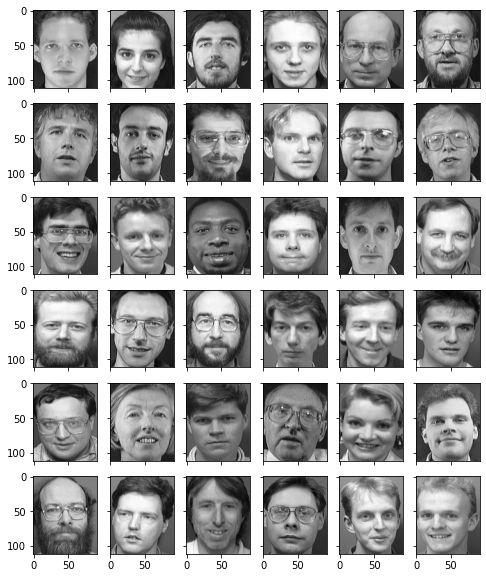

In [64]:
# Create a figure with a 6x6 grid of subplots that share the same x and y axes
figure, axis = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8, 10))

# Initialize an empty list to store the images to plot, 10 steps each time to cover as many faces as possible
images = []
for i in range(36):
    images.append(list(faces.values())[i * 10])
for i in range(36):
    row = i // 6
    col = i % 6
    axis[row][col].imshow(images[i], cmap='gray')
plt.show()

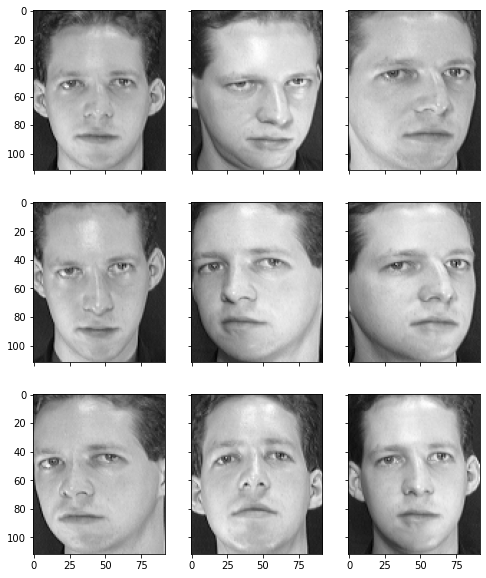

In [65]:
figure, axis = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8, 10))
images = []
for i in range(9):
    images.append(list(faces.values())[i])

# Display 9 images for the same subject to get an idea of how data looks like
for i in range(9):
    row = i // 3
    col = i % 3
    axis[row][col].imshow(images[i], cmap='gray')
plt.show()

### 2. Generate the Data Matrix and the Label vector (10 points)

In [66]:
#Get the dimensions of the grayscale image
n_x = faces[file_names[0]].shape[0]
n_y = faces[file_names[0]].shape[1]

#Initialize the data matrix array to stack the samples
data = np.empty((n_x*n_y, 0))

#Initialize list of classes
label = []
for i in range(len(faces.keys())):
    faces[file_names[i]]=faces[file_names[i]].reshape(n_x*n_y,1)
    data = np.hstack((data,faces[file_names[i]]))
    label.append(file_names[i].split("/")[0][1:])
label = np.array(label).reshape((400,1))

In [67]:
data.shape

(10304, 400)

In [68]:
label.shape

(400, 1)

### 3. Split the Dataset into Training and Testing Test sets (10 points)

In [12]:
#Split the Dataset, even rows for testing and odd for training
test_x = data.T[::2]
test_y = label[::2]
train_x = data.T[1::2]
train_y = label[1::2]

In [13]:
test_x.shape

(200, 10304)

In [14]:
test_y.shape

(200, 1)

In [15]:
train_x.shape

(200, 10304)

In [16]:
train_y.shape

(200, 1)

### 4. Classification using PCA

<img src="pca.png" width="80%" height="80%" />


In [17]:
alpha = [0.8,0.85,0.9,0.95]

In [18]:
mu = np.mean(train_x,axis=0,keepdims=True)
mu.shape

(1, 10304)

In [19]:
Z = train_x - mu
Z.shape

(200, 10304)

In [20]:
cov = np.matmul(Z.T,Z)
cov /= Z.shape[0]
cov.shape

(10304, 10304)

In [21]:
eigen_values, eigen_vectors = np.linalg.eigh(cov)

In [22]:
#Sort eigen vectors according to the descending order of corresponding eigen values
idx = eigen_values.argsort()[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

In [23]:
sum_eigen = float(np.sum(eigen_values))

In [24]:
#Choose the number of eigen vectors in the eigen face according to the accuracy we defined, we have an array alphas of all
#accuracies desired, we return a corresponding array with the number of eigen vectors starting from 0
var = 0
num_eigen = 0
final_rank = []
temp_sum = 0
for i in alpha:
    while var < i:
        temp_sum += eigen_values[num_eigen]
        var = temp_sum/sum_eigen
        num_eigen += 1
    final_rank.append(num_eigen)
    var=0
    num_eigen=0
    temp_sum=0
print(final_rank)

[36, 52, 76, 117]


In [25]:
#Get the projection matrix using the first alpha (Accuracy threshold)
projection = eigen_vectors[:,:final_rank[0]]

In [26]:
train_x.shape

(200, 10304)

In [27]:
projection.shape

(10304, 36)

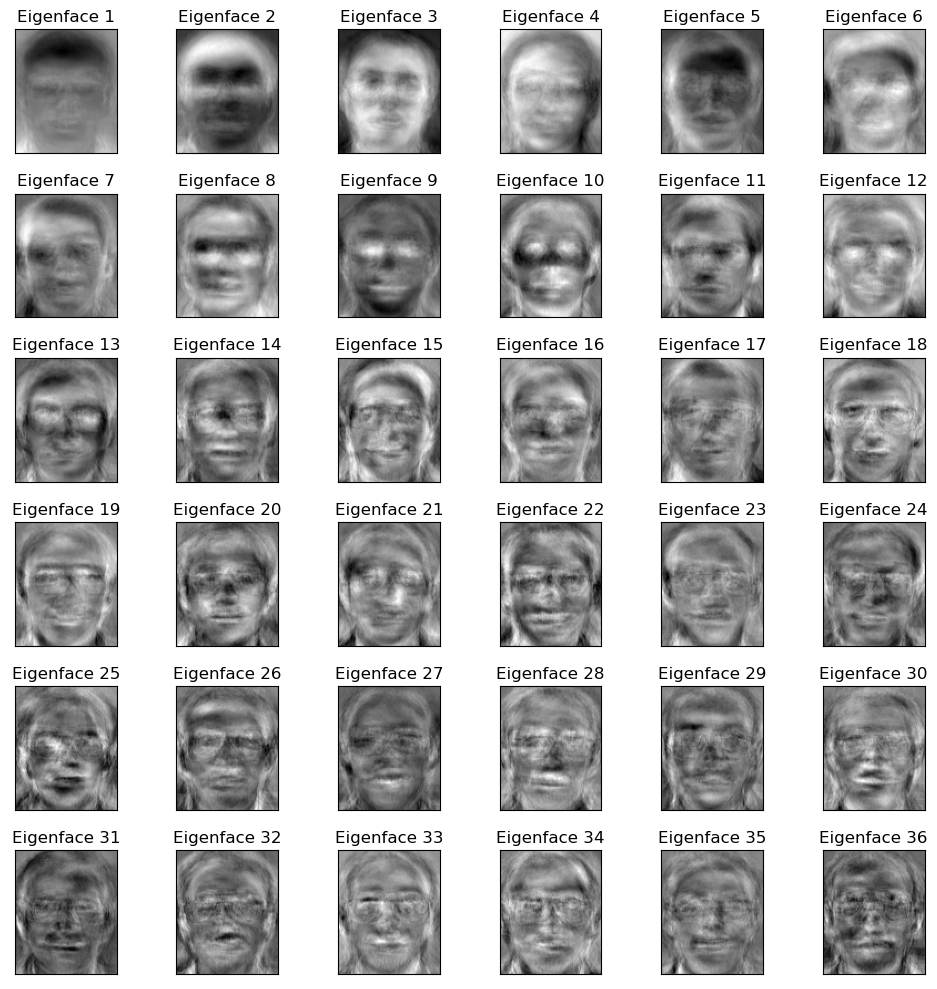

In [28]:
# Plot the eigenfaces
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(10, 10))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        index = i * 6 + j
        eigenface = eigen_vectors[:, index]
        col.imshow(eigenface.reshape(112, -1), cmap='gray')
        col.set_xticks([])
        col.set_yticks([])
        col.set_title(f"Eigenface {index+1}")
fig.tight_layout()
plt.show()

In [29]:
#Get the accuracy with respect to each alpha using KNN with 1 neighbor
print(f'K = 1')
accuracy = {}

#Get the centered train and test to project them to the new dimensions represented as the projection matrix
train_x1 = train_x - mu
test_x1 = test_x - mu
for i in range(len(final_rank)):
    projection = eigen_vectors[:,:final_rank[i]]
    train_x_new= np.dot(train_x1,projection)
    test_x_new= np.dot(test_x1,projection)
    org_accuracy = classify_knn(train_x_new, train_y, test_x_new, test_y, k=1)
    accuracy[alpha[i]] = org_accuracy
print(accuracy)

K = 1
{0.8: 0.94, 0.85: 0.945, 0.9: 0.94, 0.95: 0.935}


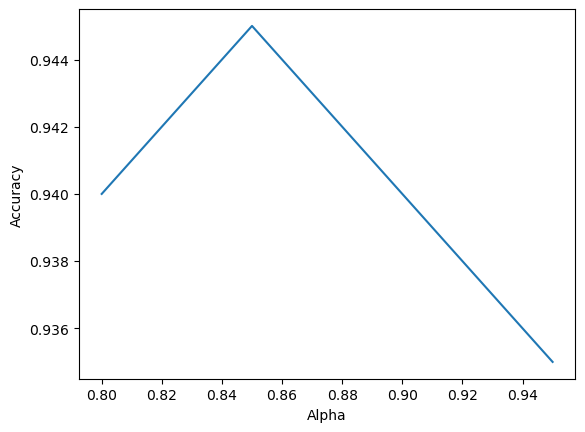

In [30]:
#plot the alpha values against the accuracy
x = accuracy.keys()
y = accuracy.values()
plt.plot(x, y)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()

### 5. Classification using LDA

<img src="lda.png" width="80%" height="80%" />


In [31]:
train_x.shape

(200, 10304)

In [32]:
train_y.shape

(200, 1)

In [33]:
train_y = np.array(train_y)

In [34]:
train_y.shape

(200, 1)

In [35]:
train_y_int = train_y.astype(int)

In [36]:
train_y_new = train_y_int.reshape(-1)

In [37]:
# Calculate the mean vector for every class [1-40]
means = np.zeros((40,10304))
for i in range(1,41):
    means[i-1] = np.mean(train_x[train_y_new == i],axis=0,keepdims=True)

In [38]:
means.shape

(40, 10304)

In [39]:
mu.shape

(1, 10304)

In [40]:
# Calculate between class scatter matrix
m = 40 # number of classes
k = 5 # number of samples per class
N = 10304 # number of features

#Initialize the between class scatter matrix to 0 having the dimensions of features x features
Sb = np.zeros((train_x.shape[1],train_x.shape[1]))
mu = mu.reshape(N, 1)
for mean in means:
    mean = mean.reshape(N, 1)
    Sb += k*np.dot((mean-mu),(mean-mu).T)
Sb.shape

(10304, 10304)

In [41]:
# Subtract the mean from each class
# Center data class matrices
Z = []
for i, mean in enumerate(means):
    idx = i+1
    mean = mean.reshape(1,N)
    
    #Query the train_x matrix using the train_y value to get the class then subtracting the mean of the corresponding class
    Z.append(train_x[train_y_new == idx] - mean)

In [42]:
Z_all = np.array(Z).reshape(-1,np.shape(Z)[-1])

In [43]:
Z_all.shape

(200, 10304)

In [44]:
#Initialize the total scatter matrix to 0
S = np.zeros((N,N))
for i in range(40):
    Z_arr = np.array(Z[i])
    S += (Z_arr.T).dot(Z_arr)

In [45]:
S_inverse=np.linalg.inv(S)

In [46]:
eigen_values_2,eigen_vectors_2 = np.linalg.eigh(np.dot(S_inverse,Sb)) 

In [47]:
#Sort eigen vectors according to the descending order of corresponding eigen values
idx = eigen_values_2.argsort()[::-1]
eigen_values_2 = eigen_values_2[idx]
eigen_vectors_2 = eigen_vectors_2[:,idx]
p = eigen_vectors_2[:,:39]

In [48]:
p.shape

(10304, 39)

In [49]:
#Projecting the train_x and test_x to the new dimensions(39 eigen vector) and fininding the accuracy of the LDA using KNN
print(f'K = 1')
d_train_x_new= np.dot(train_x,p)
d_test_x_new= np.dot(test_x,p)
org_accuracy = classify_knn(d_train_x_new, train_y, d_test_x_new, test_y,1)
print(f'Accuracy: {org_accuracy}')

K = 1
Accuracy: 0.95


### 6. Classifier Tuning

Tie breaking is done using the default rule of the sklearn library

In [50]:
#Find the accuracy for each number of neighbors in the KNN array for the different values of alphas
#Using original data not the centered data (both lead to the same results)
KNN = [1,3,5,7]
best_acc = []
for j in range(4):
    print(f'K = {KNN[j]}')
    accuracy = {}
    for i in range(len(final_rank)):
        projection = eigen_vectors[:,:final_rank[i]]
        train_x_new= np.dot(train_x,projection)
        test_x_new= np.dot(test_x,projection)
        org_accuracy = classify_knn(train_x_new, train_y, test_x_new, test_y, k=KNN[j])
        accuracy[alpha[i]] = org_accuracy
        if alpha[i] == 0.95:
            best_acc.append(org_accuracy)
    print(accuracy)
print(best_acc)

K = 1
{0.8: 0.94, 0.85: 0.945, 0.9: 0.94, 0.95: 0.935}
K = 3
{0.8: 0.84, 0.85: 0.86, 0.9: 0.875, 0.95: 0.885}
K = 5
{0.8: 0.815, 0.85: 0.795, 0.9: 0.8, 0.95: 0.785}
K = 7
{0.8: 0.765, 0.85: 0.785, 0.9: 0.765, 0.95: 0.775}
[0.935, 0.885, 0.785, 0.775]


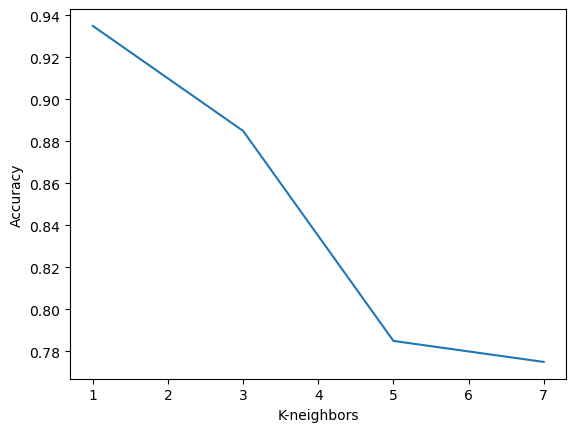

In [51]:
#plotting PCA accuracy of the highest alpha against number of neighbors
x = KNN
y = best_acc
plt.plot(x, y)
plt.xlabel("K-neighbors")
plt.ylabel("Accuracy")
plt.show()

In [52]:
#Find the accuracy for each number of neighbors in the KNN array
KNN = [1,3,5,7]
LDA_accuracies=[]
for j in range(4):
    print(f'K = {KNN[j]}')
    train_x_new= np.dot(train_x,p)
    test_x_new= np.dot(test_x,p)
    org_accuracy = classify_knn(train_x_new, train_y, test_x_new, test_y, k=KNN[j])
    print(f"Accuracy={org_accuracy}")
    LDA_accuracies.append(org_accuracy)
print(LDA_accuracies)

K = 1
Accuracy=0.95
K = 3
Accuracy=0.895
K = 5
Accuracy=0.85
K = 7
Accuracy=0.805
[0.95, 0.895, 0.85, 0.805]


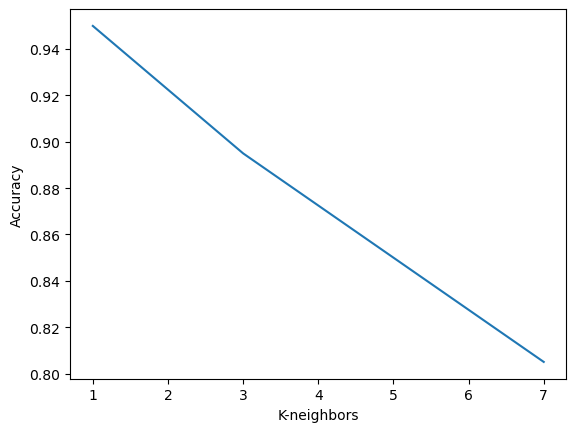

In [53]:
#plotting LDA accuracy against number of neighbors
x = KNN
y = LDA_accuracies
plt.plot(x, y)
plt.xlabel("K-neighbors")
plt.ylabel("Accuracy")
plt.show()

### 7. Compare vs Non-Face Images

In [54]:
# Initialize an empty dictionary to store the loaded images
non_faces = {}

# Open the Zip archive and iterate over the files
with zipfile.ZipFile("non_image.zip") as folder:
    for filename in folder.namelist():

        # Check if the file is a PGM image
        if filename.endswith('.jpg'):

            # Open the file and read its contents into a buffer
            with folder.open(filename) as image:
                arr = np.frombuffer(image.read(), np.uint8)

            # Decode the buffer as a grayscale image using OpenCV
            # and store it in the dictionary
            non_faces[filename] = cv.imdecode(arr, cv.IMREAD_GRAYSCALE)
            non_faces[filename] = cv.resize(non_faces[filename] , (92, 112))


In [55]:
non_faces['non_image/airplane/airplane_0003.jpg'].shape

(112, 92)

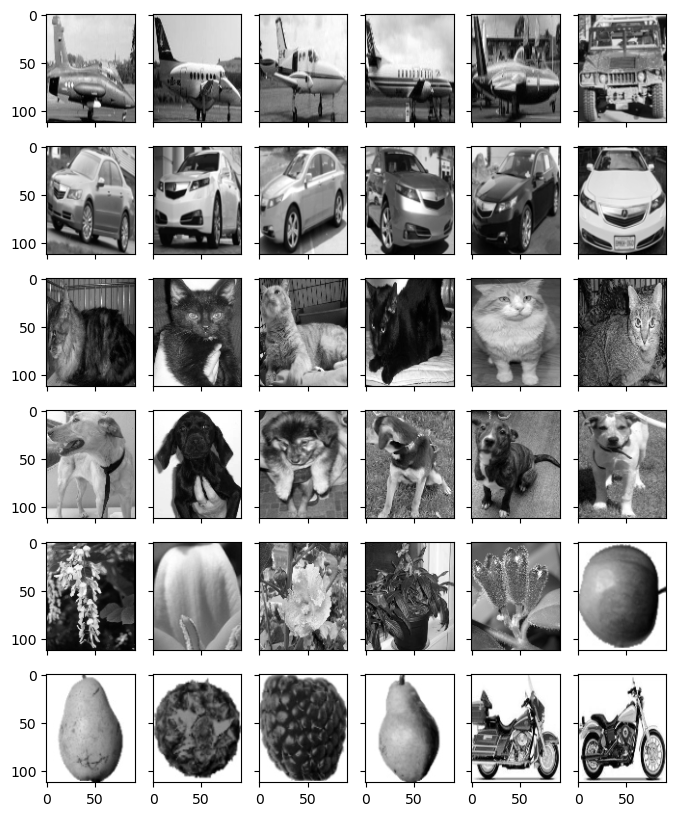

In [56]:
# Create a figure with a 6x6 grid of subplots that share the same x and y axes
figure, axis = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8, 10))

# Initialize an empty list to store the images to plot, 10 steps each time to cover as many faces as possible
images = []
for i in range(36):
    images.append(list(non_faces.values())[i * 10])
for i in range(36):
    row = i // 6
    col = i % 6
    axis[row][col].imshow(images[i], cmap='gray')
plt.show()

In [57]:
len(non_faces.keys())

400

In [58]:
file_names = list(non_faces.keys())

#Get the dimensions of the grayscale image
n_x = non_faces[file_names[0]].shape[0]
n_y = non_faces[file_names[0]].shape[1]

#Initialize the data matrix array to stack the samples
data_non_faces = np.empty((n_x*n_y, 0))

#Initialize list of classes
label = []
for i in range(len(non_faces.keys())):
    non_faces[file_names[i]]=non_faces[file_names[i]].reshape(n_x*n_y,1)
    data_non_faces = np.hstack((data_non_faces,non_faces[file_names[i]]))
    label.append(file_names[i].split("/")[0][1:])

In [59]:
test_x_non_faces = data_non_faces.T[::2]
train_x_non_faces = data_non_faces.T[1::2]

In [60]:
test_y_faces = np.ones((200,1))
train_y_faces = np.ones((200,1))
test_y_non_faces = np.zeros((200,1))
train_y_non_faces = np.zeros((200,1))

In [61]:
test_x.shape

(200, 10304)

In [62]:
test_x_non_faces.shape

(200, 10304)

In [63]:
train_x=np.vstack((train_x,train_x_non_faces))
test_x=np.vstack((test_x,test_x_non_faces))
test_y=np.vstack((test_y_faces,test_y_non_faces))
train_y=np.vstack((train_y_faces,train_y_non_faces))

In [88]:
# Class for PCA
class PCA():
    def __init__(self):
        print("Starting PCA")
    
    def compute_mean(self):
        self.mean = np.mean(self.data,axis=0,keepdims=True)

    def center(self):
        self.Z = self.data - self.mean
        
    def cov(self):
        self.covar = (self.Z.T).dot(self.Z)
        self.covar /= self.Z.shape[0]
#         print(self.covar.shape)
        
    def eigen_decomp(self):
        self.eigen_val,self.eigen_vector = np.linalg.eigh(self.covar)
        idx = self.eigen_val.argsort()[::-1]
        self.eigen_val = self.eigen_val[idx]
        self.eigen_vector = self.eigen_vector[:,idx]
        
    def project(self):
        self.test_x = test_x
    
    def reduce(self,alpha):
        sum_eigen=float(np.sum(self.eigen_val))
        self.alpha = alpha
        var = 0
        num_eigen = 0
        temp_sum = 0
        while var < self.alpha:
            temp_sum += self.eigen_val[num_eigen]
            var = temp_sum/sum_eigen
            num_eigen += 1
        self.dimensions = num_eigen
#         print(f"Number of eigenvectors: {self.dimensions}")

    def project(self,test):
        self.test_x = test
        self.projection=self.eigen_vector[:,:self.dimensions]
        self.new_train_x=self.data.dot(self.projection)
        self.new_test_x=self.test_x.dot(self.projection)
    
    def classify(self,k,test_y,train_y):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(self.new_train_x, train_y)
        self.accuracy = knn.score(self.new_test_x, test_y)
        print(f"{self.alpha}: {self.accuracy}")
        
    def start(self,data):
        self.data = data
        self.compute_mean()
        self.center()
        self.cov()
        self.eigen_decomp()
    

In [65]:
pca = PCA()
pca.start(train_x)

Starting PCA


In [66]:
KNN=[1,3,5,7]
for j in range(4):
    print(f'K = {KNN[j]}')
    for i in range(len(alpha)):
        pca.reduce(alpha[i])
        pca.project(test_x)
        pca.classify(KNN[j],test_y,train_y)

K = 1
0.8: 0.915
0.85: 0.91
0.9: 0.8925
0.95: 0.8825
K = 3
0.8: 0.885
0.85: 0.8675
0.9: 0.8525
0.95: 0.8175
K = 5
0.8: 0.8575
0.85: 0.835
0.9: 0.8175
0.95: 0.79
K = 7
0.8: 0.8375
0.85: 0.8225
0.9: 0.81
0.95: 0.78


In [89]:
#class for LDA
class LDA():
    def __init__(self):
        print("Starting LDA")
        
    def compute_mean(self):
        self.mean_faces = np.mean(self.faces_data,axis=0,keepdims=True)
        self.mean_nonfaces = np.mean(self.nonfaces_data,axis=0,keepdims=True)

    def split_data(self):
        self.faces_data = self.data[:200,:]
        self.nonfaces_data = self.data[200:,:]
        
    def center(self):
        self.Z_faces = self.faces_data - self.mean_faces
        self.Z_nonfaces = self.nonfaces_data - self.mean_nonfaces
        
    def compute_B(self):
        
        # B -- Between class scatter matrix
        d = np.reshape(self.mean_faces,(10304,1)) - np.reshape(self.mean_nonfaces,(10304,1))
        self.B = d.dot(d.T)

    
    def compute_S(self):
        self.S_1 = self.Z_faces.T.dot(self.Z_faces)
        self.S_2 = self.Z_nonfaces.T.dot(self.Z_nonfaces)
        self.S = self.S_1 + self.S_2
        
    def compute_eigen(self):
        self.M = np.linalg.inv(self.S).dot(self.B)
        self.eigen_val,self.eigen_vector = np.linalg.eigh(self.M)
        idx = self.eigen_val.argsort()[::-1]
        self.eigen_val = self.eigen_val[idx]
        self.eigen_vector = self.eigen_vector[:,idx]
            
    def project(self,test,n):
        self.n = n
        self.test_x = test
        self.projection=self.eigen_vector[:,:n]
        self.new_train_x=self.data.dot(self.projection)
        self.new_test_x=self.test_x.dot(self.projection)
    
    def classify(self,k,test_y,train_y):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(self.new_train_x, train_y)
        self.accuracy = knn.score(self.new_test_x, test_y)
        print(f"{self.n} eigenvectors : {self.accuracy}")
        

    def start(self,data):
        self.data = data
        self.split_data()
        self.compute_mean()
        self.center()
        self.compute_B()
        self.compute_S()
        self.compute_eigen()
    

In [68]:
lda = LDA()
lda.start(train_x)

Starting LDA


In [69]:
KNN=[1,3,5,7]
for j in range(4):
    print(f'K = {KNN[j]}')
    lda.project(test_x,1)
    lda.classify(KNN[j],test_y,train_y)

K = 1
1 eigenvectors : 0.76
K = 3
1 eigenvectors : 0.7675
K = 5
1 eigenvectors : 0.7925
K = 7
1 eigenvectors : 0.785


In [70]:
KNN=[1,3,5,7]
for j in range(4):
    print(f'K = {KNN[j]}')
    lda.project(test_x,40)
    lda.classify(KNN[j],test_y,train_y)

K = 1
40 eigenvectors : 0.935
K = 3
40 eigenvectors : 0.91
K = 5
40 eigenvectors : 0.9125
K = 7
40 eigenvectors : 0.905


In [90]:
# Criticize the accuracy measure for large number of non-faces
# images in the training data

# PCA

# Assuming alpha  = 0.9 and k = 1
# Range of samples vary from 50 to 400, split evenly between
# training and testing while keeping the face image dataset as it is
n_i = [50,100,150,200]
accuracies_PCA=[]
for n in n_i:
    print(f"Running PCA with {n} samples in non-faces VS 200 samples in faces")
    pca = PCA()
    test_x = data.T[::2]
    test_y = label[::2]
    train_x = data.T[1::2]
    train_y = label[1::2]
    train_x=np.vstack((train_x,train_x_non_faces[:n,:]))
    test_x=np.vstack((test_x,test_x_non_faces[:n,:]))
    test_y=np.vstack((test_y_faces,test_y_non_faces[:n,:]))
    train_y=np.vstack((train_y_faces,train_y_non_faces[:n,:]))
    pca.start(train_x)
    pca.reduce(0.9)
    pca.project(test_x)
    pca.classify(1,test_y,train_y)
    accuracies_PCA.append(pca.accuracy)

Running PCA with 50 samples in non-faces VS 200 samples in faces
Starting PCA
0.9: 0.904
Running PCA with 100 samples in non-faces VS 200 samples in faces
Starting PCA
0.9: 0.8266666666666667
Running PCA with 150 samples in non-faces VS 200 samples in faces
Starting PCA
0.9: 0.8742857142857143
Running PCA with 200 samples in non-faces VS 200 samples in faces
Starting PCA
0.9: 0.8925


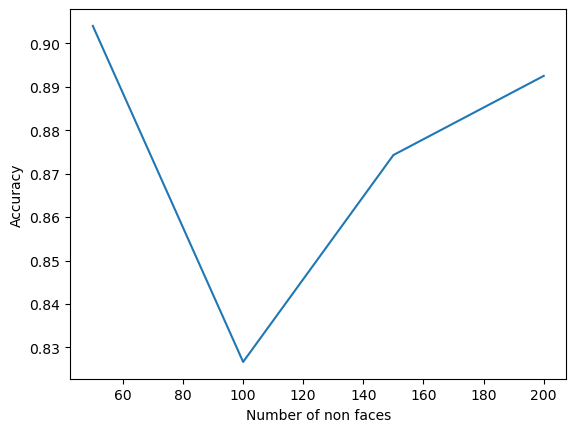

In [91]:
#plotting PCA accuracy against number of pictures in non face dataset
x = [50,100,150,200]
#y = [0.904,0.8266,0.87428571,0.8925]
y=accuracies_PCA
plt.plot(x, y)
plt.xlabel("Number of non faces")
plt.ylabel("Accuracy")
plt.show()

In [92]:
# LDA

# Assuming alpha  = 0.9 and k = 1
# Range of samples vary from 50 to 400, split evenly between
# training and testing while keeping the face image dataset as it is
n_i = [50,100,150,200]
accuracies_LDA=[]
for n in n_i:
    print(f"Running LDA with {n} samples in non-faces VS 200 samples in faces")
    lda = LDA()
    test_x = data.T[::2]
    test_y = label[::2]
    train_x = data.T[1::2]
    train_y = label[1::2]
    train_x=np.vstack((train_x,train_x_non_faces[:n,:]))
    test_x=np.vstack((test_x,test_x_non_faces[:n,:]))
    test_y=np.vstack((test_y_faces,test_y_non_faces[:n,:]))
    train_y=np.vstack((train_y_faces,train_y_non_faces[:n,:]))
    lda.start(train_x)
    lda.project(test_x,1)
    lda.classify(1,test_y,train_y)
    accuracies_LDA.append(lda.accuracy)

Running LDA with 50 samples in non-faces VS 200 samples in faces
Starting LDA
1 eigenvectors : 0.904
Running LDA with 100 samples in non-faces VS 200 samples in faces
Starting LDA
1 eigenvectors : 0.8166666666666667
Running LDA with 150 samples in non-faces VS 200 samples in faces
Starting LDA
1 eigenvectors : 0.8228571428571428
Running LDA with 200 samples in non-faces VS 200 samples in faces
Starting LDA
1 eigenvectors : 0.76


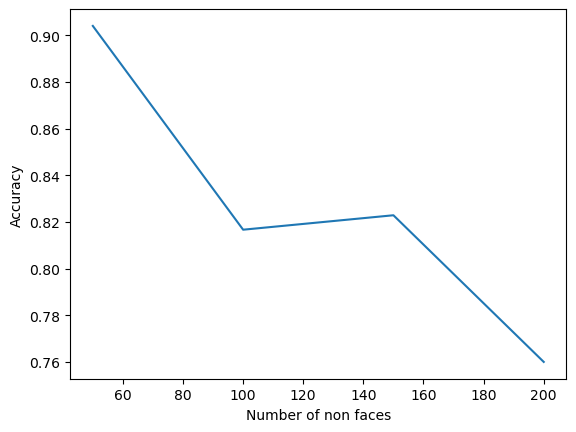

In [93]:
#plotting LDA accuracy against number of pictures in non face dataset
x = [50,100,150,200]
#y = [0.96,0.933,0.917,0.935]
y=accuracies_LDA
plt.plot(x, y)
plt.xlabel("Number of non faces")
plt.ylabel("Accuracy")
plt.show()

### 8. Bonus

In [79]:
#Get the dimensions of the grayscale image
n_x = faces[file_names_2[0]].shape[0]
n_y = faces[file_names_2[0]].shape[1]

#Initialize the data matrix array to stack the samples
data = np.empty((n_x*n_y, 0))

label = []
for i in range(len(faces.keys())):
    faces[file_names_2[i]]=faces[file_names_2[i]].reshape(n_x*n_y,1)
    data = np.hstack((data,faces[file_names_2[i]]))
    label.append(file_names_2[i].split("/")[0][1:])
label = np.array(label).reshape((400,1))

In [80]:
# Using different train/test split 7-3 instead of 5-5
data_new = data.T
test_x = np.empty((0,10304))
test_y =  np.empty((0,3*40))
train_x = np.empty((0,10304))
train_y =np.empty((0,7*40))
train_samples = 7
test_samples = 3
# iterate through the dataset in steps of 10 rows
for i in range(0, 400, 10):
    # extract the training samples and append to the training array
    train_x = np.append(train_x, data_new[i:i+train_samples,:],axis=0)
    train_y = np.append(train_y, label[i:i+train_samples])
    # extract the testing samples and append to the testing array
    test_x = np.append(test_x, data_new[i+train_samples:i+train_samples+test_samples,:],axis=0)
    test_y = np.append(test_y,label[i+train_samples:i+train_samples+test_samples])
train_y = train_y.reshape(280,1)
test_y = test_y.reshape(120,1)

In [84]:
pca = PCA()
pca.start(train_x)
KNN=[1,3,5,7]
for j in range(4):
    print(f'K = {KNN[j]}')
    pca.reduce(0.95)
    pca.project(test_x)
    pca.classify(KNN[j],test_y,train_y)

Starting PCA
K = 1
0.95: 0.9416666666666667
K = 3
0.95: 0.9
K = 5
0.95: 0.875
K = 7
0.95: 0.7916666666666666


In [94]:
lda = LDA()
lda.start(train_x)
KNN=[1,3,5,7]
for j in range(4):
    print(f'K = {KNN[j]}')
    lda.project(test_x,39)
    lda.classify(KNN[j],test_y,train_y)

Starting LDA
K = 1
39 eigenvectors : 0.93
K = 3
39 eigenvectors : 0.9075
K = 5
39 eigenvectors : 0.9075
K = 7
39 eigenvectors : 0.9025


### Variation of PCA and LDA 

### IPCA, Incremental PCA


In [70]:
data = data.T

In [84]:
from sklearn.decomposition import IncrementalPCA

# Specify the number of principal components to use
n_components = 40

# Create an instance of IncrementalPCA with the specified number of components and a batch size of 20
ipca = IncrementalPCA(n_components=n_components, batch_size=40)

# Select the odd rows of the data as the training set
train_faces = data[::2, :]

# Fit the IPCA model to the training set
ipca.fit(train_faces)

# Initialize X_train_reduced to None
X_train_reduced = None

# Iterate over the training set in batches of size ipca.batch_size
for i in range(0, train_faces.shape[0], ipca.batch_size):
    
    # Select the current batch of data
    batch = train_faces[i:i+ipca.batch_size, :]
    
    # Transform the current batch using the IPCA model
    batch_reduced = ipca.transform(batch)
    
    # Stack the reduced batch onto X_train_reduced
    if X_train_reduced is None:
        X_train_reduced = batch_reduced
    else:
        X_train_reduced = np.vstack((X_train_reduced, batch_reduced))

# Select the even rows of the data as the test set
test_faces = data[1::2, :]

# Reduce the test set using the IPCA model
X_test_reduced = ipca.transform(test_faces)

# Split the reduced training set into training and validation sets
y_train = label[::2]
y_test = label[1::2]

# # Train a KNN classifier on the reduced training set
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_reduced, y_train)

# Evaluate the accuracy of the KNN classifier on the reduced test set
accuracy = knn.score(X_test_reduced, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.88


### RLDA, Regularized LDA

In [90]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Define the number of components for LDA
n_components = 39

# Initialize the LDA model with the specified number of components and shrinkage regularization
lda = LDA(n_components=n_components)


# Split the data into training and testing sets, using odd rows for training and even rows for testing
train_faces = data[::2, :]
train_labels = label[::2]

# Fit the LDA model on the training data
lda.fit(train_faces, train_labels)

# Transform the training and testing data using the fitted model
X_train_reduced = lda.transform(train_faces)
test_faces = data[1::2, :]
X_test_reduced = lda.transform(test_faces)

# Split the reduced training data into further training and validation sets
y_train = label[::2]
y_test = label[1::2]

# Initialize a KNN classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the KNN classifier on the training data
knn.fit(X_train_reduced, y_train)

# Calculate the accuracy of the KNN classifier on the reduced validation data
accuracy = knn.score(X_test_reduced, y_test)

# Print the accuracy
print("Accuracy:", accuracy)


Accuracy: 0.915
